Epoch 1/10


C:\Users\PMYLS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5874/5874 ━━━━━━━━━━━━━━━━━━━━ 368s 62ms/step - loss: 0.0757 - mae: 0.2034 - val_loss: 0.0668 - val_mae: 0.1962 - learning_rate: 0.0010
Epoch 2/10
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 372s 60ms/step - loss: 0.0662 - mae: 0.1963 - val_loss: 0.0653 - val_mae: 0.1941 - learning_rate: 0.0010
Epoch 3/10
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 362s 62ms/step - loss: 0.0655 - mae: 0.1951 - val_loss: 0.0647 - val_mae: 0.1945 - learning_rate: 0.0010
Epoch 4/10
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 408s 69ms/step - loss: 0.0652 - mae: 0.1947 - val_loss: 0.0646 - val_mae: 0.1933 - learning_rate: 0.0010
Epoch 5/10
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 468s 74ms/step - loss: 0.0655 - mae: 0.1953 - val_loss: 0.0653 - val_mae: 0.1943 - learning_rate: 0.0010
Epoch 6/10
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 426s 72ms/step - loss: 0.0652 - mae: 0.1949 - val_loss: 0.0646 - val_mae: 0.1930 - learning_rate: 0.0010
Epoch 7/10
5874/5874 ━━━━━━━━━━━━━━━━━━━━ 427s 73ms/step - loss: 0.0650 - mae: 0.1945 - val_loss: 0.0642 - val_mae: 0.1932 - lear

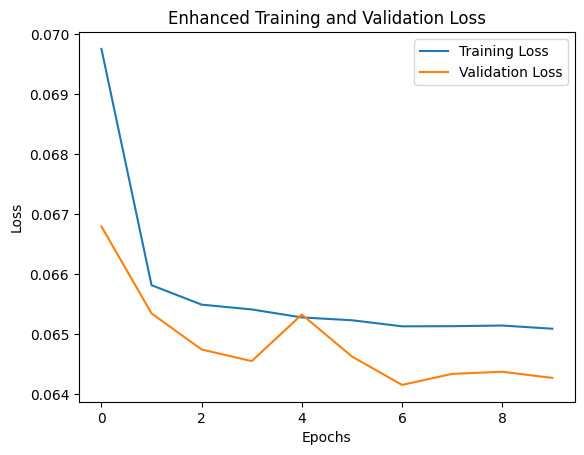

5874/5874 ━━━━━━━━━━━━━━━━━━━━ 58s 10ms/step
Improved Mean Squared Error: 0.0592
Improved Mean Absolute Error: 0.1932


C:\Users\PMYLS\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


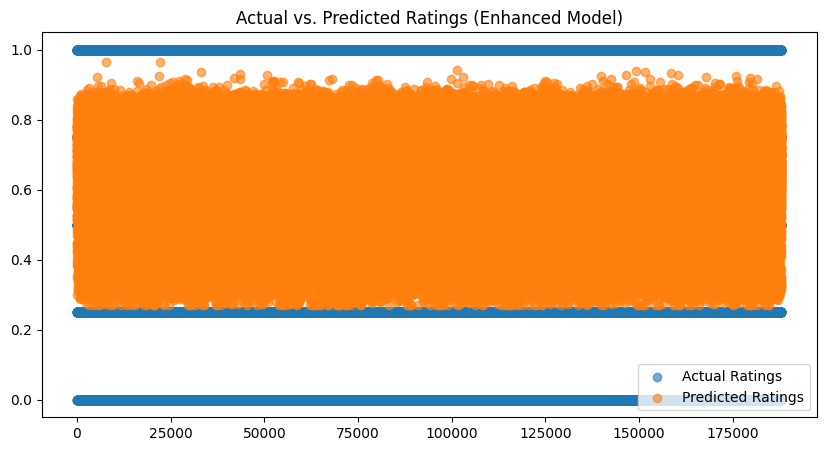

In [6]:
# Importing required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Load datasets
users_df = pd.read_csv('Dataset/users.csv')
ratings_df = pd.read_csv('Dataset/ratings.csv')
movies_df = pd.read_csv('Dataset/movies.csv')

# Merging datasets
df = pd.merge(ratings_df, movies_df, on='movie_id', how='inner')  # Merge ratings and movies
df = pd.merge(df, users_df, on='user_id', how='inner')  # Merge with users data

# Encoding categorical variables: user_id and movie_id
# encoding
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
df['user_id'] = user_encoder.fit_transform(df['user_id'])
df['movie_id'] = movie_encoder.fit_transform(df['movie_id'])

# normalization
# Normalize the ratings (scaling to 0-1 range)
scaler = MinMaxScaler()
df['rating'] = scaler.fit_transform(df[['rating']])



# Sorting by user_id and timestamp for sequential modeling
df = df.sort_values(by=['user_id', 'timestamp'])

# Preparing sequences for RNN input
def create_sequences(data, timesteps):
    users, sequences, labels = [], [], []
    grouped_data = data.groupby('user_id')
    for user_id, group in grouped_data:
        movies = group['movie_id'].values
        ratings = group['rating'].values
        for i in range(len(movies) - timesteps):
            users.append(user_id)
            sequences.append(movies[i:i+timesteps])
            labels.append(ratings[i+timesteps])
    return np.array(users), np.array(sequences), np.array(labels)

timesteps = 10  # Number of time steps in each sequence
users, sequences, labels = create_sequences(df, timesteps)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
user_train, user_test = train_test_split(users, test_size=0.2, random_state=42)

# Adjusting hyperparameters
embedding_size = 128
lstm_units = 128
dense_units = 256
dropout_rate = 0.3
learning_rate = 0.001

# Building the  RNN model


# input layers
movie_input = Input(shape=(timesteps,), name="movie_input")
user_input = Input(shape=(1,), name="user_input")

# Number of unique movies and users
n_movies = df['movie_id'].nunique()
n_users = df['user_id'].nunique()



# Embedding layers for movies and users with L2 regularization
movie_embedding = Embedding(input_dim=n_movies, output_dim=embedding_size,
                            input_length=timesteps, embeddings_regularizer=l2(1e-4))(movie_input)
user_embedding = Embedding(input_dim=n_users, output_dim=embedding_size,
                           input_length=1, embeddings_regularizer=l2(1e-4))(user_input)
user_embedding = Flatten()(user_embedding)

# LSTM layer with dropout
lstm_out = LSTM(lstm_units, activation='tanh', return_sequences=False)(movie_embedding)
lstm_out = Dropout(dropout_rate)(lstm_out)

# Concatenate user embedding with LSTM output
concat = tf.keras.layers.Concatenate()([lstm_out, user_embedding])

# Fully connected layers with dropout and L2 regularization
dense_out = Dense(dense_units, activation='relu', kernel_regularizer=l2(1e-4))(concat)
dense_out = Dropout(dropout_rate)(dense_out)
dense_out = Dense(dense_units // 2, activation='relu', kernel_regularizer=l2(1e-4))(dense_out)
output = Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-4))(dense_out)

# Building and compiling the model with a lower learning rate
model = Model(inputs=[movie_input, user_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Training the enhanced model
history = model.fit(
    [X_train, user_train], y_train,
    validation_data=([X_test, user_test], y_test),
    epochs=10,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr]
)

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Enhanced Training and Validation Loss')
plt.show()

# Predicting ratings on the test set
y_pred = model.predict([X_test, user_test])

# Evaluating the improved model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Improved Mean Squared Error: {mse:.4f}")
print(f"Improved Mean Absolute Error: {mae:.4f}")

# Visualizing actual vs. predicted ratings
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), y_test, label='Actual Ratings', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label='Predicted Ratings', alpha=0.6)
plt.legend()
plt.title('Actual vs. Predicted Ratings (Enhanced Model)')
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculating standard evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)  # Coefficient of Determination (R²)

# Displaying the metrics
print("Standard Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Standard Evaluation Metrics:
Mean Squared Error (MSE): 0.0592
Root Mean Squared Error (RMSE): 0.2433
Mean Absolute Error (MAE): 0.1932
R² Score: 0.2358
